In [1]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

## validation

In [2]:
n_genes = 100

### gse152586

In [25]:
gse152586 = pd.read_csv('../../source_with_direction/PPI/DEGs/SARS-CoV2_GSE152586_iDEP.csv')
gse152586 = gse152586[(gse152586['adj-P-Val']<=0.05)&(gse152586['Symbol'].notnull())].sort_values('logFC')
gse152586_activate = gse152586['Symbol'].values[-n_genes:]
gse152586_inhibit = gse152586['Symbol'].values[:n_genes]

with open(f'./gse152586_activate_top{n_genes}.txt', 'w') as f:
    f.write('\n'.join(gse152586_activate)+'\n')

with open(f'./gse152586_inhibit_top{n_genes}.txt', 'w') as f:
    f.write('\n'.join(gse152586_inhibit)+'\n')

### gse154783

In [40]:
gse154783 = pd.read_csv('../../source_with_direction/PPI/DEGs/SARS-CoV2_GSE154783_DESeq2.txt.gz',sep='\t')
gse154783 = gse154783[(gse154783['hmgb1.padj']<=0.05)&(gse154783['gene_id'].notnull())].sort_values('hmgb1.l2fc')
gse154783_activate = gse154783['gene_id'].values[:n_genes]
gse154783_inhibit = gse154783['gene_id'].values[-n_genes:]

with open(f'./gse154783_activate_top{n_genes}.txt', 'w') as f:
    f.write('\n'.join(gse154783_activate)+'\n')

with open(f'./gse154783_inhibit_top{n_genes}.txt', 'w') as f:
    f.write('\n'.join(gse154783_inhibit)+'\n')

### gse152418

In [3]:
gse152418 = pd.read_csv('./GSE152418_iDEP.csv')
gse152418 = gse152418[(gse152418['Ctrl-COV___padj']<=0.05)&(gse152418['Symbol'].notnull())].sort_values('Ctrl-COV___log2FoldChange')
gse152418_activate = gse152418['Symbol'].values[-n_genes:]
gse152418_inhibit = gse152418['Symbol'].values[:n_genes]

with open(f'./gse152418_activate_top{n_genes}.txt', 'w') as f:
    f.write('\n'.join(gse152418_activate)+'\n')

with open(f'./gse152418_inhibit_top{n_genes}.txt', 'w') as f:
    f.write('\n'.join(gse152418_inhibit)+'\n')

### gse171110

In [4]:
gse171110 = pd.read_csv('./GSE171110_iDEP.csv')
gse171110 = gse171110[(gse171110['Ctrl-COV___padj']<=0.05)&(gse171110['Symbol'].notnull())].sort_values('Ctrl-COV___log2FoldChange')
gse171110_activate = gse171110['Symbol'].values[-n_genes:]
gse171110_inhibit = gse171110['Symbol'].values[:n_genes]

with open(f'./gse171110_activate_top{n_genes}.txt', 'w') as f:
    f.write('\n'.join(gse171110_activate)+'\n')

with open(f'./gse171110_inhibit_top{n_genes}.txt', 'w') as f:
    f.write('\n'.join(gse171110_inhibit)+'\n')

## run on CMAP clue.io

## annotate clinical trial

In [64]:
clinicaltrial = pd.read_csv('../../map_drugs/clinicaltrial.csv')
clinicaltrial_all = clinicaltrial['ChEMBL'].unique()

In [65]:
cmapID_map = pd.read_csv('./cmap_IDmap.txt',sep='\t', header=None)
cmapID_map = cmapID_map.drop_duplicates(0)
cmapID_map = pd.Series(index=cmapID_map[0].values, data=cmapID_map[1].values)

In [66]:
gse152586_res = pd.read_csv('./GSE152586-50_cmap.txt',sep='\t')
gse152586_res['ChEMBL'] = gse152586_res['Name'].map(cmapID_map)
gse152586_res = gse152586_res[gse152586_res['ChEMBL'].notnull()].drop_duplicates('ChEMBL')
gse152586_res['Clinical Trial'] = 1
gse152586_res['Clinical Trial'] = gse152586_res['Clinical Trial'].where(gse152586_res['ChEMBL'].isin(clinicaltrial_all), 0)
gse152586_res['prediction'] = gse152586_res['Score'] - gse152586_res['Score'].min()
gse152586_res['prediction'] = gse152586_res['prediction']/gse152586_res['prediction'].max()

In [67]:
gse154783_res = pd.read_csv('./GSE154783-50_cmap.txt',sep='\t')
gse154783_res['ChEMBL'] = gse154783_res['Name'].map(cmapID_map)
gse154783_res = gse154783_res[gse154783_res['ChEMBL'].notnull()].drop_duplicates('ChEMBL')
gse154783_res['Clinical Trial'] = 1
gse154783_res['Clinical Trial'] = gse154783_res['Clinical Trial'].where(gse154783_res['ChEMBL'].isin(clinicaltrial_all), 0)
gse154783_res['prediction'] = gse154783_res['Score'] - gse154783_res['Score'].min()
gse154783_res['prediction'] = gse154783_res['prediction']/gse154783_res['prediction'].max()

## ROC curve

In [68]:
jianhua_res = pd.read_csv('../../map_drugs/drugs_rank.csv')
jianhua_res['prediction'] = jianhua_res['Rating Score']-jianhua_res['Rating Score'].min()
jianhua_res['prediction'] = jianhua_res['prediction']/jianhua_res['prediction'].max()

In [69]:
jianhua_res = jianhua_res[jianhua_res['CHEMBL ID'].isin(gse152586_res['ChEMBL'].unique())]
gse152586_res = gse152586_res[gse152586_res['ChEMBL'].isin(jianhua_res['CHEMBL ID'].unique())]
gse154783_res = gse154783_res[gse154783_res['ChEMBL'].isin(jianhua_res['CHEMBL ID'].unique())]

In [70]:
len(gse152586_res['ChEMBL'].unique())

935

## ROC

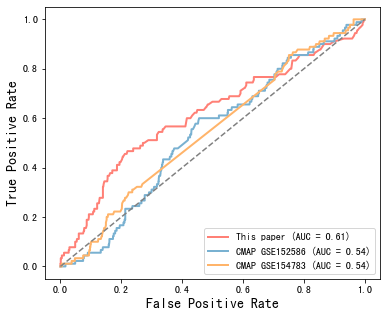

In [71]:
f, ax = plt.subplots(figsize=(6,5))

def draw_roc(df, name, color):
    y_label = df['Clinical Trial'].values
    y_pre = df['prediction'].values
    fpr, tpr, _ = roc_curve(y_label, y_pre, pos_label=1)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, '-', label=f'{name} (AUC = {roc_auc:.2f})', lw=2, color=color)

draw_roc(jianhua_res, 'This paper','#FF8076')
draw_roc(gse152586_res, 'CMAP GSE152586','#79B1D1')
draw_roc(gse154783_res, 'CMAP GSE154783','#FFB46A')
ax.plot([0, 1], [0, 1], 'k--', color='grey')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
# ax.set_title('ROC Curve')
ax.legend(loc="lower right")
# f.savefig('./Fig3c.pdf')

## PR

In [72]:
from sklearn.metrics import precision_recall_curve, average_precision_score

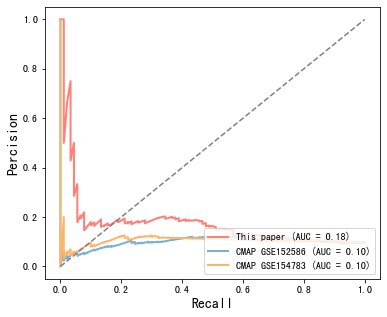

In [73]:
f, ax = plt.subplots(figsize=(6,5))

def draw_roc(df, name, color):
    y_label = df['Clinical Trial'].values
    y_pre = df['prediction'].values
    percision, recall, _ = precision_recall_curve(y_label, y_pre)
    aupr = average_precision_score(y_label, y_pre)
    ax.plot(recall, percision, '-', label=f'{name} (AUC = {aupr:.2f})', lw=2, color=color)

draw_roc(jianhua_res, 'This paper','#FF8076')
draw_roc(gse152586_res, 'CMAP GSE152586','#79B1D1')
draw_roc(gse154783_res, 'CMAP GSE154783','#FFB46A')
ax.plot([0, 1], [0, 1], 'k--', color='grey')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_ylabel('Percision', fontsize=14)
ax.set_xlabel('Recall', fontsize=14)
# ax.set_title('ROC Curve')
ax.legend(loc="lower right")
f.savefig('./AUPR.pdf')

## Overlap with other methods

In [ ]:
{'PNAS': 'DatasetS8.xlsx',
 'chenfeixiong': 'Drug_screening.xlsx',
 }


In [57]:
jianhua_res = pd.read_csv('../../map_drugs/drugs_rank.csv')

In [58]:
overlap = jianhua_res[['Drug', 'CHEMBL ID', 'Clinical Phase','Clinical Trial']].copy()
overlap['Rank in our method'] = overlap.index+1

In [59]:
pnas = pd.read_excel('./overlap/Barabasi.xlsx')
pnas = pnas.drop_duplicates('ChEMBL')
pnas = pd.Series(index=pnas['ChEMBL'].values, data=pnas['Rank'].values)
overlap['Rank in Gysi, D. M. et al.'] = overlap['CHEMBL ID'].map(pnas)

In [60]:
feixiong = pd.read_excel('./overlap/feixiong.xlsx')
feixiong = feixiong.drop_duplicates('ChEMBL')
feixiong = pd.Series(index=feixiong['ChEMBL'].values, data=feixiong['Rank'].values)
overlap['Rank in Zhou, Y. et al.'] = overlap['CHEMBL ID'].map(feixiong)

In [61]:
overlap = overlap[(overlap.iloc[:,-2]<=500)&(overlap.iloc[:,-1]<=500)&(overlap.iloc[:,-3]<=500)]

In [62]:
for col in overlap.columns[2:]:
    overlap[col] = overlap[col].astype(int)

In [74]:
len(overlap)

22

In [75]:
pnas

CHEMBL163          1
CHEMBL64           2
CHEMBL564085       3
CHEMBL799          4
CHEMBL76           5
                ... 
CHEMBL428880     973
CHEMBL918        974
CHEMBL1493       975
CHEMBL3301675    976
CHEMBL734        977
Length: 958, dtype: int64

In [76]:
a = jianhua_res[:500]['CHEMBL ID'].unique()

In [81]:
b = pnas.iloc[:500].index
c = feixiong.iloc[:500].index

In [82]:
from matplotlib_venn import venn2,venn2_circles,venn3,venn3_circles

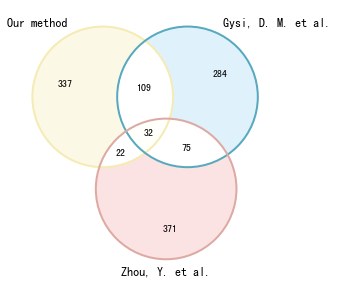

In [84]:
f, ax = plt.subplots(figsize=(5, 5))
g = venn3([set(a), set(b), set(c)],
          ax=ax,
          set_colors=['#F8EFC1', '#B1DEF3','#F9BABA'],
          set_labels=['Our method', 'Gysi, D. M. et al.','Zhou, Y. et al.'])
v = venn3_circles(
    [set(a), set(b), set(c)],
    ax=ax,
)
v[0].set_edgecolor('#F5EBB4')
v[1].set_edgecolor('#57A9BF')
v[2].set_edgecolor('#DDA9A2')
# ax.set_title('All CoVs')